In [ ]:
%pip install owslib pandas shapely matplotlib

### Imports

In [30]:
from owslib.wps import WebProcessingService, ComplexDataInput, monitorExecution
from owslib import wps
import matplotlib
import json
import pandas as pd
import logging
import sys
from ipyleaflet import Map, GeoJSON, basemaps

In [31]:
# Set up owslib logging, to set relevant output
logger = logging.getLogger("owslib")
logger.setLevel(logging.WARNING)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.WARNING)
logger.addHandler(handler)

### Consts - Change these to affect the data retrieved

In [32]:
ENDPOINT="https://funcwps.ternlandscapes.org.au/wps/"
DATASET="smips"  # options are "smips" or "aet"
LAYER="totalbucket"  # options are "totalbucket" or "SMindex" for smips, or "ETa" for "aet".
STARTDATE="2019-01-01"
ENDDATE="2020-01-01"
# Enter your POINT as GeoJSON
MYPOINT='{"type": "Point", "coordinates": [150.1458, -25.515018]}'

### Define a connection to the server

In [33]:
server = WebProcessingService(ENDPOINT, verbose=False)

In [34]:
print('WPS Identification type: %s' % server.identification.type)
print('WPS Identification title: %s' % server.identification.title)
print('WPS Identification abstract: %s' % server.identification.abstract)
for operation in server.operations:
    print('WPS Operation: %s' % operation.name)
for process in server.processes:
    print('WPS Process: identifier=%s title=%s' % (process.identifier, process.title))

WPS Identification type: WPS
WPS Identification title: TERN Landscapes Functional Data WPS Server
WPS Identification abstract: The Functional Data Processing Server from TERN Landscapes
WPS Operation: GetCapabilities
WPS Operation: DescribeProcess
WPS Operation: Execute
WPS Process: identifier=sleep title=Sleep Process
WPS Process: identifier=temporalDrill title=Temporal
WPS Process: identifier=subset1d title=SubSet 1D
WPS Process: identifier=subset2d title=SubSet 2D
WPS Process: identifier=stats2d title=Stats 2D


In [35]:
process = server.describeprocess("temporalDrill")
print('WPS Process: identifier=%s' % process.identifier)
print('WPS Process: title=%s' % process.title)
print('WPS Process: abstract=%s' % process.abstract)
for input in process.dataInputs:
    print('Process input: identifier=%s, data type=%s, minOccurs=%d, maxOccurs=%d' % (input.identifier, input.dataType, input.minOccurs, input.maxOccurs))
for output in process.processOutputs:
    print('Process output: identifier=%s, data type=%s' % (output.identifier, output.dataType))

WPS Process: identifier=temporalDrill
WPS Process: title=Temporal
WPS Process: abstract=Get timeseries value of a single pixel through time
Process input: identifier=datasetId, data type=string, minOccurs=1, maxOccurs=1
Process input: identifier=startDate, data type=date, minOccurs=1, maxOccurs=1
Process input: identifier=endDate, data type=date, minOccurs=1, maxOccurs=1
Process input: identifier=point, data type=ComplexData, minOccurs=1, maxOccurs=1
Process output: identifier=download_link, data type=string
Process output: identifier=csv, data type=ComplexData


### Optional - Visualize point

In [36]:
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[-25.128, 135.588], zoom=4)
m.add_layer(GeoJSON(data=json.loads(MYPOINT)))
m

Map(center=[-25.128, 135.588], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

### Set up to send request, first create inputs

In [37]:
point_input = ComplexDataInput(MYPOINT, mimeType="application/vnd.geo+json", schema="http://geojson.org/geojson-spec.html#point")

### Trigger process to begin (process executes asynchronously)

In [38]:
resp = server.execute(
    "temporalDrill",
    mode="async",
    inputs=[("datasetId", f"{DATASET}:{LAYER}"), ("point", point_input), ("startDate", STARTDATE), ("endDate", ENDDATE)],
    output=[("csv", False, "text/csv")]
)

### Wait for process to complete (polls every 2 seconds)

In [39]:
while not resp.isComplete():
    print("Waiting for process...")
    resp.checkStatus(sleepSecs=2)
print("Done.")

Waiting for process...
Done.


### Get result csv into a dataframe

In [40]:
first_output = next(iter(resp.processOutputs))
data = "".join(d for d in first_output.data)
df = pd.read_csv(io.StringIO(data))
df

,date,totalbucket
0,2019-01-02T00:00:00+00:00,26.786512
1,2019-01-10T00:00:00+00:00,37.805000
2,2019-01-03T00:00:00+00:00,26.132128
3,2019-01-06T00:00:00+00:00,23.969456
4,2019-01-01T00:00:00+00:00,26.897610
...,...,...
361,2019-01-14T00:00:00+00:00,29.694395
362,2019-12-28T00:00:00+00:00,6.474553
363,2019-12-30T00:00:00+00:00,3.085174
364,2019-12-29T00:00:00+00:00,4.545843


### We can plot it too

<AxesSubplot:xlabel='date'>

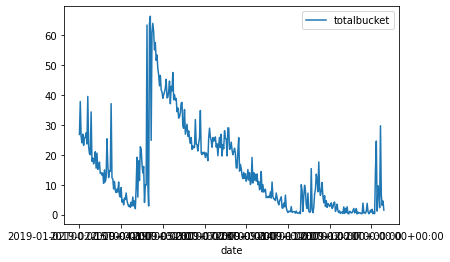

In [41]:
df.plot.line(x="date", y="totalbucket")